# Comparação de métodos de classificação

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import common as com
import logistic_regression as logreg
import knn
import statistical_classifiers as stat

x, y = datasets.load_iris(return_X_y=True); label_names = datasets.load_iris()['target_names']
#x, y = datasets.load_digits(return_X_y=True); label_names = datasets.load_digits()['target_names']
#x, y = datasets.load_wine(return_X_y=True); label_names = datasets.load_wine()['target_names']
#x, y = datasets.load_breast_cancer(return_X_y=True); label_names = datasets.load_breast_cancer()['target_names']
#data = datasets.fetch_olivetti_faces(); x, y = data['data'], data['target']; label_names = np.unique(data['target'])

print("Número de padrões: %d" % x.shape[0])
print("Número de atributos: %d" % x.shape[1])
print("Número de classes: %d" % np.unique(y).shape[0])

Número de padrões: 150
Número de atributos: 4
Número de classes: 3


## Divisão treino-teste

In [2]:
np.random.seed(12345)

number_train = int(np.ceil(0.7*(x.shape[0])))
random_index = np.random.permutation(x.shape[0])
train_index = random_index[:number_train+1]
test_index = random_index[number_train+1:]

x_train = x[train_index]
x_test = x[test_index]
y_train = y[train_index]
y_test = y[test_index]

print("Número de padrões de treinamento: %d" % len(y_train))
print("Número de padrões de teste: %d" % len(y_test))

Número de padrões de treinamento: 106
Número de padrões de teste: 44


## Normalização dos dados

In [3]:
normalize_data = True

if normalize_data:
    x_mean = np.mean(x_train, axis=0)        
    x_train -= x_mean
    x_std = np.std(x_train, axis=0)
    index_not_zero = x_std > 0
    x_train[:,index_not_zero] /= x_std[index_not_zero]
    
    x_test -= x_mean
    x_test[:,index_not_zero] /= x_std[index_not_zero]

## Criação do conjunto de validação

In [4]:
number_validation = int(np.ceil(0.3*(x_train.shape[0])))
number_train_validation = x_train.shape[0] - number_validation

random_index = np.random.permutation(x_train.shape[0])
train_index = random_index[:number_train_validation+1]
validation_index = random_index[number_train_validation+1:number_train_validation+number_validation+1]

x_train_validation, x_validation = x_train[train_index], x_train[validation_index]
y_train_validation, y_validation = y_train[train_index], y_train[validation_index]

print("Conjunto de treinamento: %d amostras" % y_train_validation.shape[0])
print("Conjunto de validação: %d amostras" % y_validation.shape[0])

Conjunto de treinamento: 75 amostras
Conjunto de validação: 31 amostras


## One hot encoding

In [5]:
y_train_encoding = np.zeros((y_train.shape[0], max(y)+1))
for i in range(y_train_encoding.shape[0]):
    y_train_encoding[i,y_train[i]] = 1
y_train_validation_encoding = np.zeros((y_train_validation.shape[0], max(y)+1))
for i in range(y_train_validation_encoding.shape[0]):
    y_train_validation_encoding[i,y_train_validation[i]] = 1
y_validation_encoding = np.zeros((y_validation.shape[0], max(y)+1))
for i in range(y_validation_encoding.shape[0]):
    y_validation_encoding[i,y_validation[i]] = 1
y_test_encoding = np.zeros((y_test.shape[0], max(y)+1))
for i in range(y_test_encoding.shape[0]):
    y_test_encoding[i,y_test[i]] = 1

## Treinamento e avaliação de modelos de classificação

### Regressão logística

In [6]:
print("[LogisticRegression] Selecionando modelos...")

#num_epochs = min([100*x_train.shape[0], 10**4])
num_epochs = 500
grid_search = np.logspace(-5, 0, 25) # alpha
validation_list = []
for i in range(grid_search.shape[0]):
    alpha = grid_search[i]
    
    model_logreg = logreg.gd(x=x_train_validation, y=y_train_validation_encoding,
                              alpha=alpha, num_epochs=num_epochs, compute_loss=False)
    pred = np.argmax(logreg.predict(model_logreg['w'], x_validation), axis=1)
    wrong_index_validation = y_validation != pred
    validation_list.append(np.mean(wrong_index_validation))
   
best_alpha = grid_search[np.argmin(validation_list)] 

print("[LogisticRegression] Melhor modelo encontrado: alpha=%.2e" % (best_alpha))

[LogisticRegression] Selecionando modelos...
[LogisticRegression] Melhor modelo encontrado: alpha=5.62e-02


In [7]:
print("[LogisticRegression] Treinando modelo...")
model_logreg = logreg.gd(x=x_train, y=y_train_encoding, alpha=best_alpha, num_epochs=num_epochs, compute_loss=False)

print("[LogisticRegression] Avaliando modelo...")
pred_logreg = np.argmax(logreg.predict(model_logreg['w'], x_test), axis=1)

wrong_index_test_logreg = pred_logreg != y_test
print("[LogisticRegression] Taxa de erro no teste: %.2f%%" % (100*np.mean(wrong_index_test_logreg)))

[LogisticRegression] Treinando modelo...
[LogisticRegression] Avaliando modelo...
[LogisticRegression] Taxa de erro no teste: 6.82%


### Análise de Discriminante Gaussiano

In [8]:
print("[GaussianDiscriminantAnalysis] Treinando modelo...")
model_gda = stat.create_GDA(x=x_train, y=y_train)

print("[GaussianDiscriminantAnalysis] Avaliando modelo...")
pred_gda = stat.predict_GDA(model=model_gda, x=x_test)

wrong_index_test_gda = pred_gda != y_test
print("[GaussianDiscriminantAnalysis] Taxa de erro no teste: %.2f%%" % (100*np.mean(wrong_index_test_gda)))

[GaussianDiscriminantAnalysis] Treinando modelo...
[GaussianDiscriminantAnalysis] Avaliando modelo...
[GaussianDiscriminantAnalysis] Taxa de erro no teste: 2.27%


### Naive Bayes Gaussiano

In [9]:
print("[GaussianNaiveBayes] Treinando modelo...")
model_gnb = stat.create_GNB(x=x_train, y=y_train)

print("[GaussianNaiveBayes] Avaliando modelo...")
pred_gnb = stat.predict_GNB(model=model_gnb, x=x_test)

wrong_index_test_gnb = pred_gnb != y_test
print("[GaussianNaiveBayes] Taxa de erro no teste: %.2f%%" % (100*np.mean(wrong_index_test_gnb)))

[GaussianNaiveBayes] Treinando modelo...
[GaussianNaiveBayes] Avaliando modelo...
[GaussianNaiveBayes] Taxa de erro no teste: 6.82%


### KNN

In [10]:
print("[KNN] Selecionando modelos...")

grid_search = np.meshgrid(np.arange(1, 26, 2), # k
                          ['euclidean', 'manhattan', 'mahalanobis']) # distance metric
validation_list = []
validation_list_index = []
for i in range(grid_search[0].shape[0]):
    for j in range(grid_search[1].shape[1]):
        k = grid_search[0][i,j]
        distance_metric = grid_search[1][i,j]   
        
        wrong_index_validation = y_validation != knn.predict_class(x=x_train_validation, y=y_train_validation,
                                                                   x_new=x_validation,
                                                                   k=k, distance_metric=distance_metric)
        validation_list.append(np.mean(wrong_index_validation))
        validation_list_index.append((i,j))
   
best_i, best_j = validation_list_index[np.argmin(validation_list)]   
best_k = grid_search[0][best_i, best_j]
best_distance_metric = grid_search[1][best_i, best_j]

print("[KNN] Melhor modelo encontrado: K=%d, 'distance_metric'=%s" % (best_k, best_distance_metric))

[KNN] Selecionando modelos...
[KNN] Melhor modelo encontrado: K=1, 'distance_metric'=euclidean


In [11]:
print("[KNN] Avaliando modelo...")
pred_knn = knn.predict_class(x_train, y_train, x_test, k=best_k, distance_metric=best_distance_metric)

wrong_index_test_knn = pred_knn != y_test
print("[KNN] Taxa de erro no teste: %.2f%%" % (100*np.mean(wrong_index_test_knn)))

[KNN] Avaliando modelo...
[KNN] Taxa de erro no teste: 6.82%


### Árvore de decisão

In [12]:
print("[DecisionTree] Selecionando modelos...")
best_criterion = "gini"
model_tree = DecisionTreeClassifier(criterion="gini", presort=True, random_state=1)
model_tree.fit(x_train_validation, y_train_validation)
validation_error = np.mean(y_validation != model_tree.predict(x_validation))

model_tree = DecisionTreeClassifier(criterion="entropy", presort=True, random_state=1)
model_tree.fit(x_train_validation, y_train_validation)
if np.mean(y_validation != model_tree.predict(x_validation)) < validation_error:
    best_criterion = "entropy"
print("[DecisionTree] Melhor modelo encontrado: 'criterion'=%s" % (best_criterion))

print("[DecisionTree] Treinando modelo...")
model_tree = DecisionTreeClassifier(criterion=best_criterion, presort=True, random_state=1)
model_tree.fit(x_train, y_train)

print("[DecisionTree] Avaliando modelo...")
pred_tree = model_tree.predict(x_test)

wrong_index_test_tree = pred_tree != y_test
print("[DecisionTree] Taxa de erro no teste: %.2f%%" % (100*np.mean(wrong_index_test_tree)))

[DecisionTree] Selecionando modelos...
[DecisionTree] Melhor modelo encontrado: 'criterion'=gini
[DecisionTree] Treinando modelo...
[DecisionTree] Avaliando modelo...
[DecisionTree] Taxa de erro no teste: 11.36%


## Sumário dos resultados

In [13]:
model_names = ["LogisticRegression", "GaussianDiscriminantAnalysis", "GaussianNaiveBayes", "KNN", "DecisionTree"]
model_preds = [pred_logreg, pred_gda, pred_gnb, pred_knn, pred_tree]

print("Sumário dos resultados de classificação:\n")
for i in range(len(model_names)):
    print("[%s] Taxa de erro no teste: %.2f%%" % (model_names[i], 100*np.mean(y_test != model_preds[i])))

Sumário dos resultados de classificação:

[LogisticRegression] Taxa de erro no teste: 6.82%
[GaussianDiscriminantAnalysis] Taxa de erro no teste: 2.27%
[GaussianNaiveBayes] Taxa de erro no teste: 6.82%
[KNN] Taxa de erro no teste: 6.82%
[DecisionTree] Taxa de erro no teste: 11.36%


Matrizes de confusão:

Confusion matrix - LogisticRegression
[[13  0  0]
 [ 0 11  1]
 [ 0  2 17]]


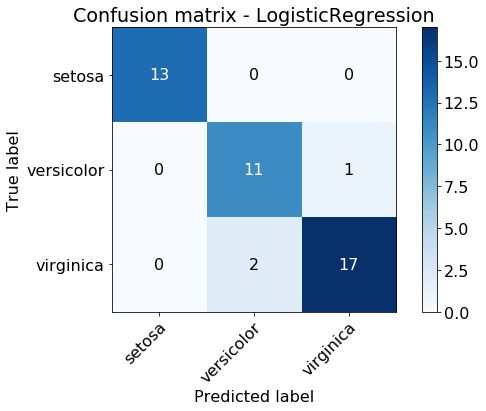

Confusion matrix - GaussianDiscriminantAnalysis
[[13  0  0]
 [ 0 12  0]
 [ 0  1 18]]


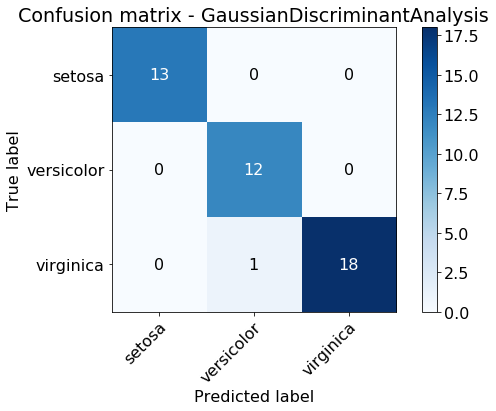

Confusion matrix - GaussianNaiveBayes
[[13  0  0]
 [ 0 11  1]
 [ 0  2 17]]


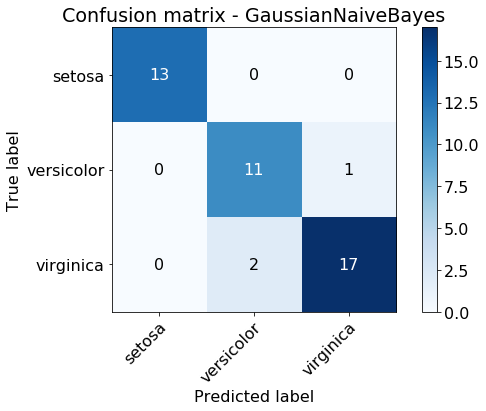

Confusion matrix - KNN
[[13  0  0]
 [ 0 11  1]
 [ 0  2 17]]


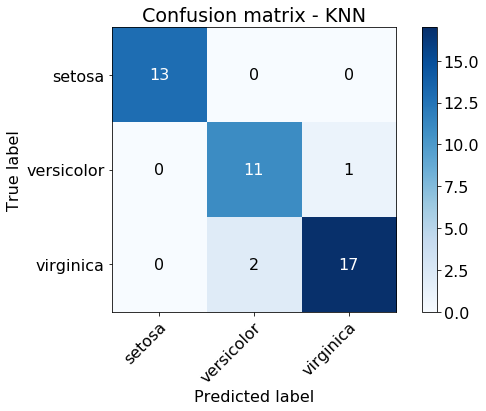

Confusion matrix - DecisionTree
[[13  0  0]
 [ 0 11  1]
 [ 0  4 15]]


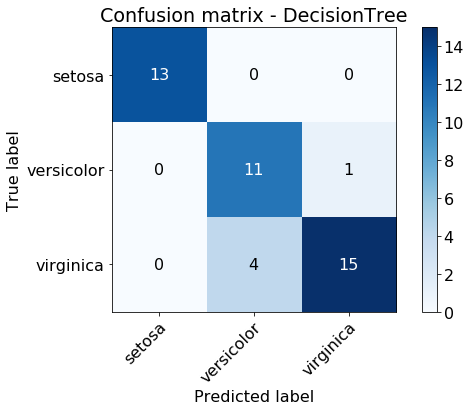

In [14]:
print("Matrizes de confusão:\n")
for i in range(len(model_names)):
    com.plot_confusion_matrix(y_test, y_pred=model_preds[i], classes=label_names,
                          title="Confusion matrix - " + model_names[i])
    plt.show()

In [15]:
if np.unique(y_train).shape[0] == 2:    
    print("Métricas para classificação binária:\n")
    positive_class = 0
    negative_class = 1 - positive_class
    for i in range(len(model_names)):
        tp = np.sum(model_preds[i][np.argwhere(y_test == positive_class)] == positive_class)
        fn = np.sum(model_preds[i][np.argwhere(y_test == positive_class)] == negative_class)
        fp = np.sum(model_preds[i][np.argwhere(y_test == negative_class)] == positive_class)
        revocacao = tp / (tp + fn)
        precisao = tp / (tp + fp)
        f_score = 2 * revocacao * precisao / (revocacao + precisao)
        print("[%s] Revocação no teste: %.4f" % (model_names[i], revocacao))
        print("[%s] Precisão no teste: %.4f" % (model_names[i], precisao))
        print("[%s] F1 score no teste: %.4f" % (model_names[i], f_score))